In [1]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.special import erfc
from rich.console import Console
from rich.panel import Panel
console=Console()
sp.init_printing()

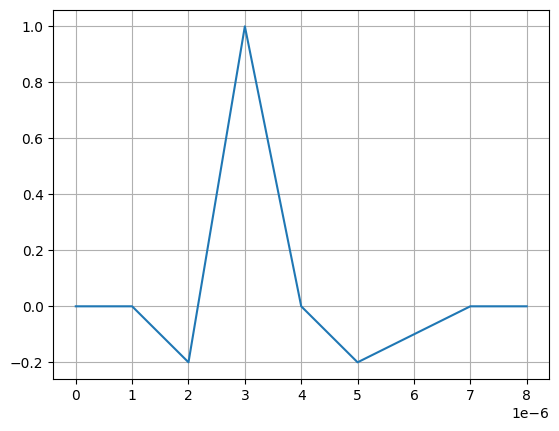

In [2]:
h = [0,0, -0.2, 1, 0, -0.2,-0.1, 0,0]
t = np.arange(0, 9, 1) * 1e-6
plt.plot(t, h)

plt.grid()

plt.show()

In [3]:
def RB_without(h, t):
    last_zero = len(h) - 1
    max_idx = np.argmax(h)
    j = 0
    pj = -1
    nodes = []
    mnidx = 0
    print(max_idx)
    
    for i in range(len(h)):
        if h[i] == 0:
            if j != pj:
                nodes.append(i)
                pj = j
            nodes[-1] = i
        elif i == max_idx:
            nodes.append(i)
            mnidx = len(nodes) - 1
            j += 1
        else:
            j += 1
    if max(np.diff(nodes)) == min(np.diff(nodes)):
        return 1 / np.abs(t[nodes[1]] - t[nodes[0]]), (
            max_idx - max(np.diff(nodes)),
            max(np.diff(nodes)) + max_idx,
        )
    return 1 / np.abs(t[np.argmax(np.diff(nodes))] - t[max_idx]), (
        max_idx - max(np.diff(nodes)),
        max(np.diff(nodes)) + max_idx,
    )

In [4]:
RB,(pzero,nzero) = RB_without(h[::-1],t)
print(pzero,nzero)
nzero,pzero = len(h)-pzero-1,len(h)-nzero-1
print(f"Rb without ISI: {RB} bps")

print(f"Rb without ISI: {RB/1000} Kbps")
pzero,nzero

5
2 8
Rb without ISI: 200000.00000000003 bps
Rb without ISI: 200.00000000000003 Kbps


(0, 6)

# LTE

## Params

In [5]:
LTE=[3,2]

In [6]:
def gen_coef(LTE, n):
    return sp.symbols(
        ["C_{" + str(i) + "\\," + str(n) + "}" for i in range(1 - LTE[0], LTE[1] + 1)]
    )

In [7]:
def get_last_zero(harr):
    return nzero

In [8]:
def gen_y(h):
    max_idx = np.argmax(h)
    y = np.zeros(len(h))
    y[max_idx] = 1
    return y

In [9]:
def gen_eq(harr, coef, yarr, nzero):
    res = np.convolve(coef, harr)
    res[nzero - 1] -= 1
    return res

In [10]:
coef = gen_coef(LTE, 0)
yarr = gen_y(h)
eqs = gen_eq(h,coef,yarr,nzero)

In [11]:
for eq in eqs:
    display(eq)

In [12]:
def zero_forcing(eqs, coef, harr):
    max_idx = np.argmax(harr)
    cvals = [
        sp.solve(eqs[i : i + len(coef)])
        for i in range(max_idx - 1, len(eqs) - len(coef))
    ]
    cvals = [cval for cval in cvals if len(cval) == len(coef)]
    errors = [np.abs(sum(eq.subs(cval) for eq in eqs if eq != 0)) for cval in cvals]
    print("error for each set of coeficients:", errors)
    print("result for each set of equations:")
    for cval in cvals:
        display(cval)
    print("selected set of equations:")
    for eq in eqs[
        max_idx - 1 + np.argmin(errors) : max_idx - 1 + np.argmin(errors) + len(coef)
    ]:
        display(eq)
    return cvals[np.argmin(errors)]

In [13]:
coef_0 = zero_forcing(eqs, coef, h)
coef_0

error for each set of coeficients: [16.0000000000000, 0.205665024630542, 2.08465608465608, 2.09375000000000, 1]
result for each set of equations:


selected set of equations:


In [30]:
def peak_dist(eqs, coef_0, h):
    max_idx = np.argmax(h)
    DP = np.sum([np.abs(h) for n, h in enumerate(h) if n != max_idx]) / h[max_idx]
    print(max_idx + get_last_zero(h))
    DP_p = np.sum(
        [
            np.abs(eq.subs(coef_0))
            for n, eq in enumerate(eqs)
            if n != (max_idx + get_last_zero(h))
        ]
    ) / np.abs(eqs[max_idx + get_last_zero(h)].subs(coef_0)+1)
    return DP, DP_p

In [31]:
DP,DP_p=peak_dist(eqs, coef_0, h)
print(f"DP: {DP}")
print(f"DP': {DP_p}")

9
DP: 0.5
DP': 0.160156250000000


In [32]:
max_idx = np.argmax(h)
d_min = h[max_idx] - DP
d_min_p = np.abs(eqs[max_idx + get_last_zero(h)].subs(coef_0) + 1) - DP_p
print(f"d_min: {d_min}")
print(f"d_min': {d_min_p}")
print(f"d_min-d_min': {d_min-d_min_p}")

d_min: 0.5
d_min': 0.785656557881773
d_min-d_min': -0.285656557881773


In [17]:
delta_SINR = (d_min_p / d_min) / sp.sqrt(
    sum([np.abs(coef_0[c]) ** 2 for n, c in enumerate(coef)])
)
print("\u0394SINR lineal:", delta_SINR.evalf())
print("\u0394SINR en dB:", sp.sympify(20 * sp.log(delta_SINR, 10)).evalf())

ΔSINR lineal: 1.46133395278277
ΔSINR en dB: 3.29498949702280


In [33]:
sigma_n_2 = 0.5  # W
x = d_min / (np.sqrt(2) * np.sqrt(sigma_n_2))
P_b = 0.5 * erfc(x)
if np.abs(np.round(x, 1) - x) > 0.015:
    print("revisar con la tabla")
console.print(
    Panel(
        f"x: {x}\nP_b: {P_b}",
        title="Without eq",
        style="bold yellow" if np.abs(np.round(x, 1) - x) > 0.015 else "bold green",
    )
)

sigma_eq = sp.sqrt(
    sigma_n_2 * sum([np.abs(coef_0[c]) ** 2 for n, c in enumerate(coef)])
)
x_p = float(d_min_p / (sigma_eq * np.sqrt(2)))
P_b_p = 0.5 * erfc(x_p)

console.print(
    Panel(
        f"x': {x_p}\nP_b': {P_b_p}",
        title="With eq",
        style="bold yellow" if np.abs(np.round(x_p, 1) - x_p) > 0.015 else "bold green",
    )
)


╭────────────────────────────────────────────────── Without eq ───────────────────────────────────────────────────╮
│ x: 0.4999999999999999                                                                                           │
│ P_b: 0.2397500610934768                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── With eq ────────────────────────────────────────────────────╮
│ x': 0.7306669763913838                                                                                          │
│ P_b': 0.15072728475193803                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [34]:
z=[0.5,0.9,1.1,-1.2,0.8,0.9,-1.1,0.7,0.9]
z_0=4
diff=0.1

In [35]:
def get_sorted_coef(coef,n):
  if type(coef)==list:
    return coef
  return [coef[sp.Symbol("C_{"+str(i)+","+str(n)+"}")] for i in range(1-LTE[0],LTE[1]+1)]

In [36]:
def compute_y(z_arr,z_0,coef,n,LTE):
  scoef=get_sorted_coef(coef,n)
  return sum([z*c for z,c in zip(z_arr[z_0-LTE[1]:z_0+LTE[0]],scoef[::-1])])

In [37]:
def compute_delta(coef,n,delta,z_arr,z_0,diff,LTE):
  scoef=get_sorted_coef(coef,n)
  y=compute_y(z_arr,z_0,coef,n,LTE)
  print("y["+str(n)+"] =",y,"e["+str(n)+"]", y-np.sign(y),)
  print("C["+str(n)+"] =", scoef[LTE[0]-1])
  eq=(delta)*np.abs(y-np.sign(y))*z_arr[z_0]-diff*scoef[LTE[0]-1]
  return np.abs(sp.solve(eq)[0])

In [38]:
def compute_next_coef(coef,n,delta,z_arr,z_0,LTE):
  scoef=get_sorted_coef(coef,n)
  y=compute_y(z_arr,z_0,coef,n,LTE)
  print("y["+str(n)+"] =",y,"e["+str(n)+"]", y-np.sign(y),)
  nextcoef=[c-delta*(y-np.sign(y))*z
            for c,z in zip(scoef[::-1],
                              z_arr[z_0-LTE[1]:z_0+LTE[0]])]
  return nextcoef

In [39]:
delta=sp.Symbol("Delta")
nextcoef=compute_next_coef(coef_0,0,delta,z,z_0,LTE)[::-1]
for eq in nextcoef:
  display(eq)

y[0] = 1.10057471264368 e[0] 0.100574712643678


In [40]:
delta_res=compute_delta(coef_0,0,delta,z,z_0,diff,LTE)
print("Δ =", delta_res)

y[0] = 1.10057471264368 e[0] 0.100574712643678
C[0] = 1.02627257799672
Δ = 1.27551020408164


In [41]:
nextcoef1=compute_next_coef(coef_0,0,delta_res,z,z_0,LTE)[::-1]
for i,eq in enumerate(nextcoef1):
  print("C",i-LTE[0]+1)
  display(eq)

y[0] = 1.10057471264368 e[0] 0.100574712643678
C -2


C -1


C 0


C 1


C 2


In [27]:
nextcoef2=compute_next_coef(nextcoef1,1,delta_res,z,z_0+1,LTE)[::-1]
for i,eq in enumerate(nextcoef2):
  print("C",i-LTE[0]+1)
  display(eq)

y[1] = 0.953817733990150 e[1] -0.0461822660098503
C -2


C -1


C 0


C 1


C 2


In [42]:
def compute_DFE(h_arr):
  idx=np.argmax(h_arr)-1
  print(idx)
  return[1/h_arr[idx]]+[-h/h_arr[idx] for h in h_arr[idx+1:]][:len(nextcoef)-1]

In [43]:
compute_DFE(h)

2
